In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
# filter warnings
warnings.filterwarnings('ignore')


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input , Dense , Dropout , Flatten,\
Conv2D,MaxPooling2D , BatchNormalization
from keras.callbacks import EarlyStopping, History
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import cv2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
path = "../input/planets-dataset/planet/planet"
os.listdir(path)



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['sample_submission.csv', 'test-jpg', 'train_classes.csv', 'train-jpg']

In [2]:
# Load the Data

train_labels = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
test_labels = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
train_images = os.path.join(path,'train-jpg')
test_images = os.path.join(path,'test-jpg')


In [3]:
#View Shape of the Train Data

print("Train data: {}".format(train_labels.shape))

Train data: (40479, 2)


In [4]:
#View Shape of the Test Data

print("Test data: {}".format(test_labels.shape))

Test data: (61191, 2)


In [5]:
# View content of the Train DF

train_labels.head(5)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
# Number of unique classes in the train dataset

train_labels['tags'].nunique()

449

<div style="font-family:Roboto;color:black; padding:20px; font-size:20px; text-align:center">

DATA PREPROCESSING
</div>

In [7]:
# Splitting

label = set()
def preprocess(tags):
    [label.add(tag) for tag in tags.split()]
    
train_labels['tags'].apply(preprocess)
label = list(label)
print(label)

['cultivation', 'cloudy', 'selective_logging', 'artisinal_mine', 'water', 'clear', 'slash_burn', 'bare_ground', 'haze', 'habitation', 'blooming', 'primary', 'partly_cloudy', 'road', 'blow_down', 'agriculture', 'conventional_mine']


In [8]:
import gc
gc.collect()

0

In [9]:
for tag in label:
    train_labels[tag] = train_labels['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
train_labels['image_name'] = train_labels['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_labels.head()

,image_name,tags,cultivation,cloudy,selective_logging,artisinal_mine,water,clear,slash_burn,bare_ground,haze,habitation,blooming,primary,partly_cloudy,road,blow_down,agriculture,conventional_mine
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0


In [10]:
# Initialize imagedatagenerator with a validation split of 0.2
gen = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)
columns = list(train_labels.columns[2:])


train_gen = gen.flow_from_dataframe(dataframe=train_labels,
                                                    directory =train_images, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))
val_gen = gen.flow_from_dataframe(dataframe=train_labels,
                                                  directory =train_images, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [11]:
gc.collect()

0

<div style="font-family:Roboto;color:black; padding:20px; font-size:20px; text-align:center">

MODELLING
</div>

In [12]:
def fbeta_(y_true, y_pred, beta = 2, epsilon = 1e-4):
    beta_squared = beta**2

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision+recall+epsilon)
    return fb

    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp

    precision = tp/(tp +fp +epsilon)
    recall = tp/(tp + fn + epsilon)

    fb = (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + epsilon)
    return fb

def acc(y_true, y_pred, epsilon = 1e-4):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp

    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32),                 axis = 1)
    return (tp + tn)/(tp + tn + fp + fn + epsilon)

In [13]:
# Define the model
def mymodel():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=17, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.1), 
                  metrics=[fbeta_, acc])
    
    return model


In [14]:
gc.collect()

0

In [15]:
model = mymodel()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [17]:
gc.collect()

623

In [18]:
 callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=0,
    baseline=None,
    restore_best_weights=True,
)

In [19]:
#step size for image data

train_step = train_gen.n // train_gen.batch_size
val_step = val_gen.n // val_gen.batch_size

In [20]:
gc.collect()

0

In [21]:
history = model.fit(x=train_gen,
                    steps_per_epoch=train_step,
                    validation_data=val_gen,
                    validation_steps=val_step,
                    epochs=5, callbacks=[callback], verbose=1) 
                    

Epoch 1/5
1012/1012 [==============================] - 976s 961ms/step - loss: 0.2071 - fbeta_: 0.7095 - acc: 0.9194 - val_loss: 0.1619 - val_fbeta_: 0.7877 - val_acc: 0.9352
Epoch 2/5
1012/1012 [==============================] - 942s 931ms/step - loss: 0.1578 - fbeta_: 0.7915 - acc: 0.9379 - val_loss: 0.1414 - val_fbeta_: 0.8214 - val_acc: 0.9430
Epoch 3/5
1012/1012 [==============================] - 965s 954ms/step - loss: 0.1440 - fbeta_: 0.8115 - acc: 0.9430 - val_loss: 0.1365 - val_fbeta_: 0.8291 - val_acc: 0.9456
Epoch 4/5
1012/1012 [==============================] - 939s 927ms/step - loss: 0.1366 - fbeta_: 0.8245 - acc: 0.9460 - val_loss: 0.1500 - val_fbeta_: 0.8030 - val_acc: 0.9414
Epoch 5/5
1012/1012 [==============================] - 938s 927ms/step - loss: 0.1285 - fbeta_: 0.8372 - acc: 0.9490 - val_loss: 0.1278 - val_fbeta_: 0.8435 - val_acc: 0.9493


In [22]:
gc.collect()

4

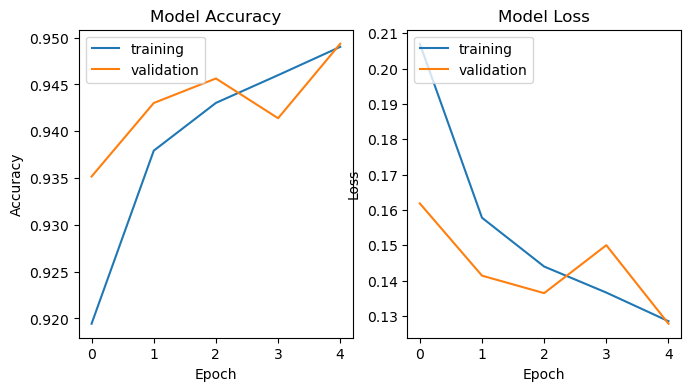

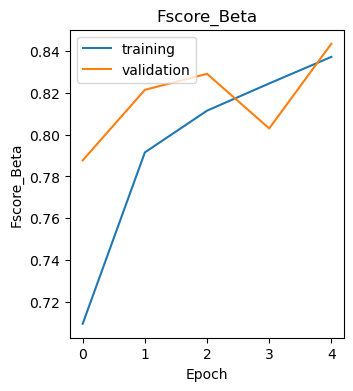

In [23]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 3)
plt.plot(history.history['fbeta_'])
plt.plot(history.history['val_fbeta_'])
plt.title('Fscore_Beta')
plt.ylabel('Fscore_Beta')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')


In [24]:
gc.collect()

7381

<div style="font-family:Roboto;color:black; padding:20px; font-size:20px; text-align:center">

PREDICTION
</div>

In [25]:
test_labels1 = test_labels.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)

test_labels1['image_name'] = test_labels1['image_name'].apply(lambda x: x+'.jpg')
test_labels1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [26]:
gc.collect()

0

In [36]:
gen2 = ImageDataGenerator(rescale = 1./255)

test_gen = gen2.flow_from_dataframe(dataframe=test_labels1,
                                                    directory =test_images, 
                                                    x_col='image_name', y_col=None, 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode=None, target_size=(128,128))

test_step = test_gen.n // test_gen.batch_size

Found 40669 validated image filenames.


In [37]:
gc.collect()

2694

In [38]:
prediction = model.predict(test_gen, steps = test_step, verbose=1)

1270/1270 [==============================] - 323s 254ms/step


In [39]:
gc.collect()

0

In [1]:
test = test_gen.filenames

result = pd.DataFrame(prediction)
result = result.apply(lambda x: ' '.join(np.array(labels)), axis=1)

result_df = pd.DataFrame({'image_name': test, 'tags': result})
result_df.head()

NameError: name 'test_gen' is not defined

In [ ]:
gc.collect()

In [ ]:

test_labels2 = test_label.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)

test_labels2['image_name'] = test_labels2['image_name'].apply(lambda x: x+'.jpg')
test_labels2.head()


In [ ]:
gc.collect()

In [ ]:
test_gen2 = gen2.flow_from_dataframe(dataframe=test_labels2,
                                            directory = test_images,
                                            x_col="image_name",
                                            y_col=None,
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(128,128))

test_step2 = test_gen2.n // test_gen2.batch_size

In [ ]:
gc.collect()

In [ ]:
prediction2 = model.predict(test_gen2, steps = test_step2, verbose=1)

In [ ]:
test2 = test_gen2.filenames

result1 = pd.DataFrame(prediction)
result1 = result1.apply(lambda x: ' '.join(np.array(label)[x >= 0.5]), axis=1)

result_df1 = pd.DataFrame({'image_name': test, 'tags': result1})
result_df1.head()

In [ ]:
final_result = pd.concat([result_df, result_df1])

final_result = final_result.reset_index().drop('index', axis =1)

print(final_result.shape)
final_result.head()

In [ ]:
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

In [ ]:
final_result.to_csv('final_submission.csv', index=False)